In [24]:
using Plots
using LaTeXStrings
using Base.Threads

using LogExpFunctions
using Distances
using WassersteinDictionaries
using GaussianProcesses

using Gridap, Gridap.FESpaces, Gridap.CellData
using SparseArrays: spzeros

using LinearAlgebra
using LineSearches
using ForwardDiff

using Test
using Statistics
using Random

include("../src/utils.jl")

snapshots_trb (generic function with 1 method)

In [119]:
### Hyperparameters

const ε = 1e-3  # entropic regularisation
const ϵ = 1e-3  # retained eigenvalue energy threshold
const nₛ = 100  # size of training set
const nₜ = 50   # size of test set
;

In [30]:
### Initial condition

const σ = sqrt(1e-3)
function f(x, x0)
  exp(-((x[1] - x0[1])^2 + (x[2] - x0[2])^2) / 2 / σ^2) / (2π*σ^2)
end

const μ_min = -0.35
const μ_max = 0.35

const N = 64
const d = 2     # spatial dimension

### FEM spaces

u(x) = 0.0
domain = (0,1,0,1)
partition = (N,N)
model = CartesianDiscreteModel(domain,partition)

highorder = 3

V₂ = FESpace(
  model,
  ReferenceFE(lagrangian,Float64,highorder),
  conformity=:H1,
  dirichlet_tags="boundary"
)
U₂ = TrialFESpace(V₂,u)

Ω = Triangulation(model)
degree = 2*highorder
dΩ = Measure(Ω,degree);

Γ = BoundaryTriangulation(model)
nb = get_normal_vector(Γ)
dΓ = Measure(Γ,degree)

L2(e) = sqrt(sum( ∫( e*e )*dΩ ))
H1(e) = sqrt(sum( ∫( e*e + ∇(e)⋅∇(e) )*dΩ ));

N_fine = highorder*N
partition_fine = (N_fine,N_fine)
model_fine = CartesianDiscreteModel(domain,partition_fine)

V₁ = FESpace(
  model_fine,
  ReferenceFE(lagrangian,Float64,1),
  conformity=:H1
)

Ψ = FESpace(
  model,
  ReferenceFE(lagrangian,Float64,3),
  conformity=:H1
)
;

In [31]:
### Training set

Random.seed!(1234)
μ̄ = trainparameterset(nₛ, μ_max, μ_min)
uₕ = snapshots(f, μ̄, V₂, U₂, dΩ);

In [32]:
### POD

C = [ sum(∫((uₕ[i]) ⋅ (uₕ[j]) )dΩ) for i in eachindex(uₕ), j in eachindex(uₕ) ]
evd = eigen(C, sortby = x -> -abs(x) )
n = get_n(evd.values, ϵ)
ϕ = get_ϕ(n, uₕ, evd, V₂, U₂);

In [33]:
### Test set

Random.seed!(4932)
μ̄ₜ = testparameterset(nₜ, μ_max, μ_min)
uₕₜ = snapshots(f, μ̄ₜ, V₂, U₂, dΩ)
uₕₜ_rb = snapshots_rb(f, μ̄ₜ, ϕ, V₂, U₂, dΩ)
ΔL2_rb = [ L2(uₕₜ_rb[i]-uₕₜ[i]) / L2(uₕₜ[i]) for i in eachindex(uₕₜ) ]
ΔH1_rb = [ H1(uₕₜ_rb[i]-uₕₜ[i]) / H1(uₕₜ[i]) for i in eachindex(uₕₜ) ];

In [34]:
### Transport calculations
c = WassersteinDictionaries.get_cost_matrix_separated(N_fine+1, d, a = [domain[1] domain[3]], b = [domain[2] domain[4]])
k = WassersteinDictionaries.get_gibbs_matrix(c, ε)

SPB = SinkhornParameters(256, ε)
SPB.debias = true
SPB.averaged_updates = false
SPB.update_potentials = false
MC = MatrixCache(N_fine+1)
SPB.tol = 1e-12


ūₕ = [ reshape( abs.(get_free_dof_values( interpolate_everywhere(Interpolable((_uₕ)⋅(_uₕ)), V₁) )),N_fine+1,N_fine+1) for _uₕ in uₕ]
for _ūₕ in ūₕ
    _ūₕ ./= sum(_ūₕ) * (1 / N_fine)^2
end
log_ūₕ = [ safe_log.(_ūₕ) for _ūₕ in ūₕ ]

Random.seed!(2424)

nᵦ = 25
ūₕᵦ = ūₕ[rand(1:nₛ,nᵦ)]

ūₕ_ref = sinkhorn_barycenter_sep([ 1/nᵦ for _ in ūₕᵦ], ūₕᵦ, k, SPB, MC)
log_ūₕ_ref = safe_log.(ūₕ_ref)
uₕ_ref = interpolate_everywhere( Interpolable( FEFunction(V₁, vec(ūₕ_ref))), Ψ);

In [ ]:
### Transport potentials

SP = SinkhornParameters(128, ε)
SP.tol = 1e-12
SP.debias = false
SP.averaged_updates = false
SP.update_potentials = true

ψ̄ᶜ = get_ψ̄ᶜ(ūₕ, ūₕ_ref, SP, MC);

In [43]:
### H¹ boundary projections

ψᶜ2 = boundary_projection(ψ̄ᶜ, N_fine, model, degree, V₁, Ψ, dΩ);

GenericMeasure()

In [50]:
### Monge embedding POD
Cψ = [ sum(∫(∇(ψᶜᵢ)⋅∇(ψᶜⱼ)*uₕ_ref)dΩ) for ψᶜᵢ in ψᶜ, ψᶜⱼ in ψᶜ ]
evdψ = eigen(Cψ, sortby = x -> -abs(x))
m = get_n(evdψ.values, ϵ)
ξᶜ = get_ϕ(m, ψᶜ, evdψ, Ψ, Ψ);

4

In [ ]:
### plot transport mode i

i = 1 # ∈ 1,2,…,m
x_cord = 0:0.01:1
surface(x_cord,x_cord, (x,y) -> ξᶜ[i](Point(x,y)) - ξᶜ[i](Point(0.5,0.5)),
        cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\xi^c_{%$i}", size = (400,400), camera = (30,30),
        legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)

In [66]:
### approximated transport potentials

λ = [ [ sum(∫(∇(_ψᶜ)⋅∇(_ξᶜ)*uₕ_ref)dΩ) for _ξᶜ in ξᶜ ] for _ψᶜ in ψᶜ ]
ψᶜᵣ = [ FEFunction(Ψ, _λ' * get_free_dof_values.(ξᶜ)) for _λ in λ ]
L2_ψ = [ sum(∫(∇(ψᶜ[i] - ψᶜᵣ[i])⋅∇(ψᶜ[i] - ψᶜᵣ[i])*uₕ_ref)dΩ) / sum(∫(∇(ψᶜ[i])⋅∇(ψᶜ[i])*uₕ_ref)dΩ) for i in eachindex(ψᶜ) ]
;

In [68]:
function c̄_transform(_λ, ξᶜ, ε = 1e-9)

    _ψᶜᵣ = FEFunction(Ψ, _λ' * get_free_dof_values.(ξᶜ))

    _ψᶜᵣ₀ = interpolate_everywhere(Interpolable(_ψᶜᵣ), V₁)

    _ψ̄ᶜᵣ = reshape( get_free_dof_values(_ψᶜᵣ₀), N_fine+1, N_fine+1)

    #_ψ̄ᶜᵣ = reshape(_λ' * get_free_dof_values.(ξᶜ), N2+1, N2+1)

    # approximate mapping to reference configuration
    _ψ̄ᵣ = zero(_ψ̄ᶜᵣ)
    WassersteinDictionaries.softmin_separated!(_ψ̄ᵣ, _ψ̄ᶜᵣ, log_ūₕ_ref, 1e-6, c, MC[:t1,Float64], MC[:t2,Float64])
    #WassersteinDictionaries.softmin_separated!(_ψ̄ᵣ, _ψ̄ᶜᵣ, log_unif, 1e-12, c, MC[:t1,Float64], MC[:t2,Float64])
    
    _ψᵣ₀ = FEFunction(V₁, vec(_ψ̄ᵣ))

    _ψᵣ = interpolate_everywhere( Interpolable(_ψᵣ₀), Ψ)

    #_ψᵣ = FEFunction(Ψ, vec(_ψ̄ᵣ)) 

    _ψᵣ
end

c̄_transform (generic function with 3 methods)

In [70]:
id = TensorValue(diagm(ones(2)))

TensorValue{2, 2, Float64, 4}(1.0, 0.0, 0.0, 1.0)

In [71]:
function pushfwd(u,ψ,V)

    T = Float64

    u_cache = Gridap.CellData.return_cache(u, Point(0,0))
    psi_cache = Gridap.CellData.return_cache(∇(ψ), Point(0,0))

    function uT(y)
        dy = Gridap.evaluate!(psi_cache, ∇(ψ), y)
        Ty = y - dy
        if Ty[1] < domain[1] || Ty[1] > domain[2] || Ty[2] < domain[3] || Ty[2] > domain[4]
            return zero(T)
        else
            return Gridap.evaluate!(u_cache, u, Ty)
        end
    end

    U = u.fe_space
    Ω = get_triangulation(u)

    dΩc = Measure(Ω,2*highorder)
    a(u,v) = ∫( u*v )*dΩc
    l(v) = ∫( v*uT )*dΩc
    op = AffineFEOperator(a,l,U,V)

    return solve(op)
end


pushfwd (generic function with 2 methods)

In [72]:
@time _Tuₕ = pushfwd(uₕ[1],ψᶜᵣ[1],V₂)

  4.203483 seconds (9.16 M allocations: 740.364 MiB, 2.18% gc time, 85.29% compilation time)


SingleFieldFEFunction():
 num_cells: 4096
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 940720462124272050

In [73]:
_Tuₕ2 = pushfwd(uₕ[1], ψᶜᵣ[1], V₂, domain, dΩ)

SingleFieldFEFunction():
 num_cells: 4096
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 940720462124272050

In [74]:
H1(_Tuₕ2 - _Tuₕ)

0.0

In [75]:
### Snapshots mapped to reference domain

Tuₕ = copy(uₕ)
for i in eachindex(uₕ) 
    Tuₕ[i] = pushfwd(uₕ[i], ψᶜᵣ[i], V₂, domain, dΩ)
end

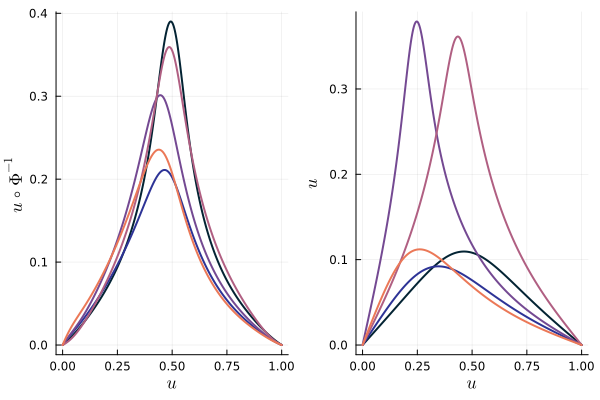

In [79]:
### plot some snapshot crossections before and after registration
cpal = palette(:thermal, 7);
plt1 = plot()
_i = 1
idxs = rand(1:nₛ,5)
for i in idxs
    plot!(0:0.001:1, x -> Tuₕ[i](Point(x,0.5)), legend = false,
    linewidth = 2, color = cpal[_i], xlabel = L"u", ylabel = L"u \circ \Phi^{-1}",
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt2 = plot()
_i = 1
for i in idxs
    plot!(0:0.001:1, x -> uₕ[i](Point(x,0.5)), legend = false,
    linewidth = 2, color = cpal[_i], xlabel = L"x", ylabel = L"u",
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plot(plt1,plt2)

In [82]:
# Registrated snapshot POD
CT = [ sum(∫( (uₕᵢ) ⋅ (uₕⱼ))dΩ) for uₕᵢ in Tuₕ, uₕⱼ in Tuₕ ]
evdT = eigen(CT, sortby = x -> -abs(x))
nₘ = get_n(evdT.values, ϵ)
ϕσ = get_ϕ(nₘ, Tuₕ, evdT, V₂, V₂)

7

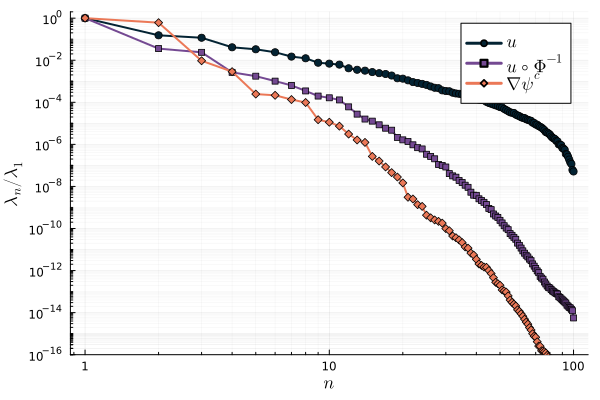

In [86]:
### Plot eigenvalue decay

nₚ = minimum((nₛ,100))
cpal = palette(:thermal, 4);
plot(abs.(evd.values[1:nₚ]) ./ evd.values[1], yaxis = :log, minorgrid = true, xaxis = :log,
yticks = 10.0 .^ (-16:2:0), xticks = ( [1,10,100], string.([1,10,100]) ),
linewidth=2, marker = :circle, xlabel = L"n", ylabel = L"\lambda_n / \lambda_1", ylim = (1e-16,2), label = L"u", color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(abs.(evdT.values[1:nₚ]) ./ evdT.values[1], linewidth=2, marker = :square, markersize = 3, label = L"u \circ \Phi^{-1}", color = cpal[2])
plot!(abs.(evdψ.values[1:nₚ]) ./ evdψ.values[1], linewidth=2, marker = :diamond, label = L"\nabla \psi^c", color = cpal[3])

In [ ]:
### plot reference basis function i

i = 1 # ∈ 1,2,…,nₘ
x_cord = 0:0.01:1
surface(x_cord,x_cord, (x,y) -> ϕσ[i](Point(x,y)),
        cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\phi_{%$i}", size = (400,400), camera = (30,30),
        legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)

In [93]:
# Gaussian process

gp = get_gp(μ̄, λ, m);

In [ ]:
# Gaussian process Plots

i = 1 # ∈ 1,2,…,m
μ̄₁ = [μ̄[i][1] for i in eachindex(μ̄)]
μ̄₂ = [μ̄[i][2] for i in eachindex(μ̄)]
_μ = [ μ̄[i][k] for k in 1:d, i in eachindex(μ̄)]

surface(gp[i]; legend = false, xlabel = L"\mu_1", ylabel = L"\mu_2", zlabel = L"w_{%$i}", 
        xlim = (μ_min,μ_max), ylim = (μ_min,μ_max), camera = (30, 45), size = (400,400),
        legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
scatter!(μ̄₁, μ̄₂, predict_y(gp[i], _μ)[1], label = false, color = :white, markersize = 2, aspectratio=1)


In [ ]:
# registered online phase

uₕₜ_trb, uₕₜ_trb_ref = snapshots_trb(f, μ̄ₜ, ϕσ, V₂, U₂, dΩ, domain, ξᶜ, gp, Ψ, V₁, N_fine, log_ūₕ_ref, MC)
ΔL2_trb = [ L2(uₕₜ_trb[i]-uₕₜ[i]) / L2(uₕₜ[i]) for i in eachindex(uₕₜ_trb) ]
ΔH1_trb = [ H1(uₕₜ_trb[i]-uₕₜ[i]) / H1(uₕₜ[i]) for i in eachindex(uₕₜ_trb) ]
;

In [104]:
# Mapping errors

Statistics.mean(L2_ψ), Statistics.std(L2_ψ; corrected=false), maximum(L2_ψ)

(0.00047632860376219116, 0.00035002615627085224, 0.0019252343492543679)

In [114]:
# L2 errors

println("registered (n = $nₘ, m = $m) \t avg.: ", Statistics.mean(ΔL2_trb), " ± ", 
        Statistics.std(ΔL2_trb; corrected=false), "\t max.: ", maximum(ΔL2_trb))
println("unregistered (n = $n, m = 0) \t avg.: ", Statistics.mean(ΔL2_rb), " ± ", 
        Statistics.std(ΔL2_rb; corrected=false), "\t max.: ", maximum(ΔL2_rb))

registered (n = 7, m = 4) 	 avg.: 0.03916102310587579 ± 0.024401336238702026	 max.: 0.14225695370837732
unregistered (n = 41, m = 0) 	 avg.: 0.07815034172686547 ± 0.06222491827226094	 max.: 0.28640171219578514


In [115]:
# H1 errors

println("registered (n = $nₘ, m = $m) \t avg.: ", Statistics.mean(ΔH1_trb), " ± ", 
        Statistics.std(ΔH1_trb; corrected=false), "\t max.: ", maximum(ΔH1_trb))
println("unregistered (n = $n, m = 0) \t avg.: ", Statistics.mean(ΔH1_rb), " ± ", 
        Statistics.std(ΔH1_rb; corrected=false), "\t max.: ", maximum(ΔH1_rb))

registered (n = 7, m = 4) 	 avg.: 0.16488549276622932 ± 0.03778718782386408	 max.: 0.25480518625602616
unregistered (n = 41, m = 0) 	 avg.: 0.304587614057424 ± 0.1345653229268867	 max.: 0.657000266088692


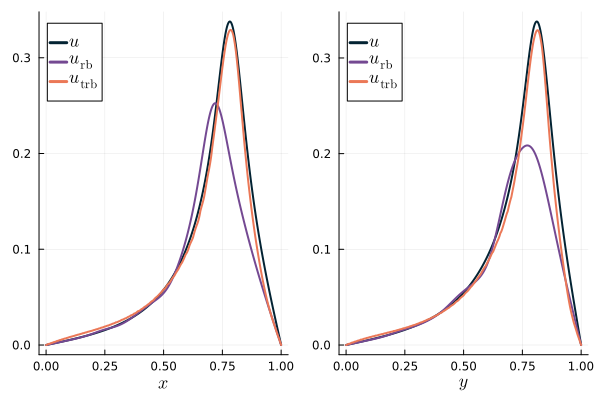

In [118]:
### print the worst case (H1 error) reconstruction

_i = argmax(ΔH1_trb)
μ = μ̄ₜ[_i]
cpal = palette(:thermal, 3+1)
plt1 = plot()
plot!(0:0.001:1, x -> uₕₜ[_i](Point([x,0.5+μ[2]])), label = L"u", xlabel = L"x",
linewidth = 2, color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_rb[_i](Point([x,0.5+μ[2]])), label = L"u_{\mathrm{rb}}",
linewidth = 2, color = cpal[2],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_trb[_i](Point([x,0.5+μ[2]])), label = L"u_{\mathrm{trb}}",
linewidth = 2, color = cpal[3],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plt2 = plot()
plot!(0:0.001:1, x -> uₕₜ[_i](Point([0.5+μ[1],x])), label = L"u", xlabel = L"y",
linewidth = 2, color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_rb[_i](Point([0.5+μ[1],x])), label = L"u_{\mathrm{rb}}",
linewidth = 2, color = cpal[2],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_trb[_i](Point([0.5+μ[1],x])), label = L"u_{\mathrm{trb}}",
linewidth = 2, color = cpal[3],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot(plt1, plt2)